In [1]:
import numpy as np
# import sklearn.model_selection
import matplotlib.pyplot as plt
from isotree import IsolationForest
from scripts import physics, dataset
import numpy as np

In [3]:
x_train, x_test = dataset.create_xtrain_xtest()
nugun = dataset.load_dataset('NuGun_preprocessed.h5', 'full_data_cyl')
tautau = dataset.load_dataset('BSM_preprocessed.h5', 'GluGluHToTauTau')

In [4]:
new_dataset, labels, _, _ = dataset.inject_signal(x_test, tautau, size='max', percentage=0.01)
# new_dataset, labels, indv_points, each_size

In [5]:
#the invariant mass calculation takes kinda long, need to find ways to make it more efficient :) 
dijet_tautau = physics.invariant_mass(tautau, type='jet')
dijet_nugun = physics.invariant_mass(nugun, type='jet')

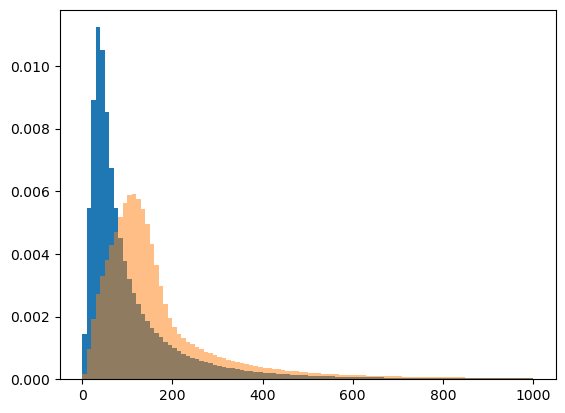

In [6]:
# this specific signal is very nice as it looks very different from bkg
plt.hist(dijet_nugun, range=(0,1000), bins=100, density=True)
plt.hist(dijet_tautau, range=(0,1000), bins=100, density=True, alpha=0.5)
pass

In [7]:
model = IsolationForest(ndim=3,ntrees=100).fit(x_train) # no reason yet for this choice of this specific model other than gut feeling :)
score = model.predict(new_dataset, output="score")

In [8]:
# this is s.t. we can compare it
score_bkg = model.predict(x_train, output="score")

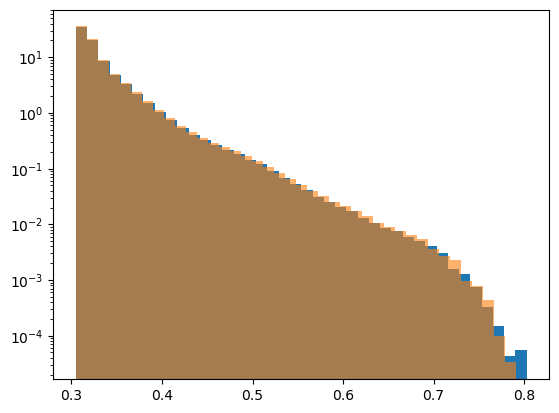

In [9]:
# we dont really see much of a "difference" until we put on the logarithmic scale
# we see that our injected signal dataset tends to have more anomalous scores than usual! 
plt.hist(score_bkg, density=True, bins=40, log=True)
plt.hist(score, density=True, alpha=0.6, bins=40, log=True)
pass

#split "score" histogram by signal vs bkg 

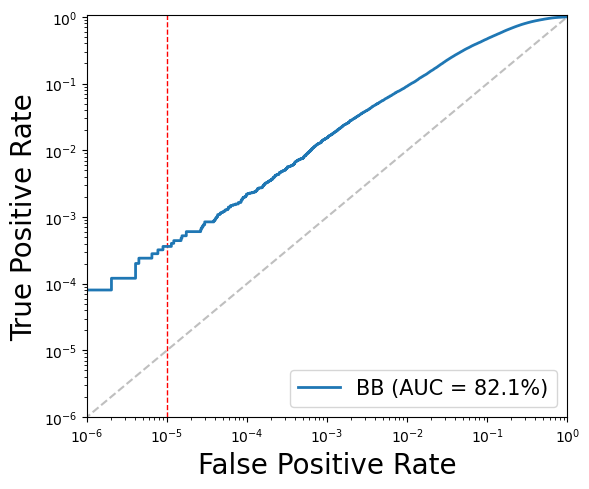

In [10]:
#let's confirm it via AUROC!

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(6, 5))
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.xlim([10**-(6), 1.0])
plt.ylim([10**-(6), 1.05])
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.xlabel('False Positive Rate',fontsize=20) # bkg efficiency
plt.ylabel('True Positive Rate',fontsize=20) # sig efficiency
plt.semilogx()
plt.semilogy()

trueVal = labels
predVal_loss = score
fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
auc_loss = auc(fpr_loss, tpr_loss)

plt.plot(fpr_loss, tpr_loss, lw=2, label='BB (AUC = %.1f%%)' % (auc_loss * 100))

plt.legend(loc='lower right',fontsize=15)
plt.tight_layout()

#looks very nice! ?

In [11]:
# AUROC can be little misleading when it comes to performance assesement of imbalanced datasets (like we have here)
# it'd be best to find our region of interest, where we care to know most about the ratio of FPR/TPR !
# like e.g. looking at the trigger rate:

In [12]:
## for L1 rate estimates from ZeroBias/SingleNuMC
def totalMinBiasRate(nCollBunch = 2500): 
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3 # in kHz

# copied from arturs notebook

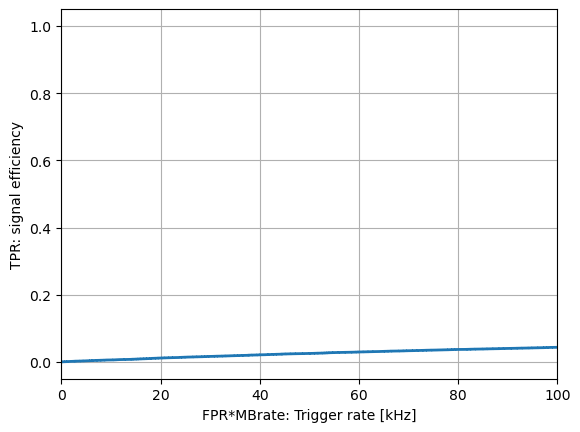

In [13]:
plt.plot(fpr_loss*totalMinBiasRate(), tpr_loss, lw=2, label='BB (AUC = %.1f%%)' % (auc_loss * 100))

plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("TPR: signal efficiency")
plt.grid()
plt.xlim(0,100)
pass
# what does this mean ? i dont know. probably that my classifier is not so good after all, showcasing the "misleadingness" of auroc here ?
# in general would be cool to re-do arturs plot on showing ""what part of phase space""" we are most sensitive too!! 

In [18]:
# we then had the suggestion of looking at S/sqrt(B). i dont really properly know how to do this yet so i just tried something with this:

def get_sig(threshold, score, labels):
    get_indices = [i for i in range(len(score)) if score[i] >= threshold]
    total_event_count = len(labels[get_indices])
    total_sig_count = np.sum(labels[get_indices])
    return total_sig_count/np.sqrt(total_event_count)


def anom_score_threshhold_scan(score, labels, step, start=np.min(score), end=np.max(score)):
    scan_range = np.linspace(start, end, num=step)
    significance = []

    for i in scan_range:
        significance.append(get_sig(i, score, labels))
    return significance, scan_range


sb, scan_range = anom_score_threshhold_scan(score, labels, step=200)

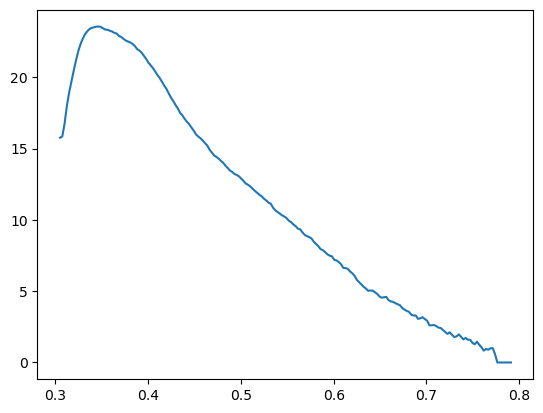

In [19]:
#what does this mean ? i dont know. i thought maybe it means that the max is then the perfect place to do our separation of "anomaly" score?
plt.plot(scan_range, sb)

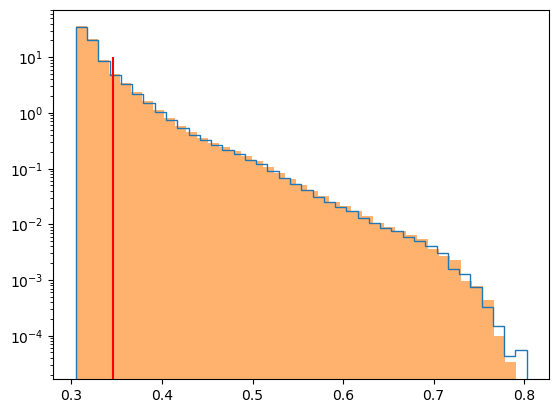

In [20]:
plt.hist(score_bkg, density=True, bins=40, log=True, histtype='step')
plt.hist(score, density=True, alpha=0.6, bins=40, log=True)
plt.vlines(scan_range[np.argmax(sb)], 0,10, color='red')
pass

# and you kinda see it! in my opinion..

In [17]:
# maybe now w this "optimal split" we can then also look at other metrics, like F1 and so on..... but idk ! 
# i think the split either way has to be decided based on what "phase space area" we are interested in.......

In [ ]:
## then the rest is just me playing around !

In [32]:
score_len = len(score)
get_indices_anom = [i for i in range(score_len) if score[i] >= scan_range[np.argmax(sb)]]
get_indices_other = [i for i in range(score_len) if score[i] < scan_range[np.argmax(sb)]]

In [33]:
anom = new_dataset[get_indices_anom]
other = new_dataset[get_indices_other]

In [35]:
dijet_anom = physics.invariant_mass(anom, 'jet')
dijet_other = physics.invariant_mass(other, 'jet')

In [36]:
dijet_all = physics.invariant_mass(new_dataset, 'jet')

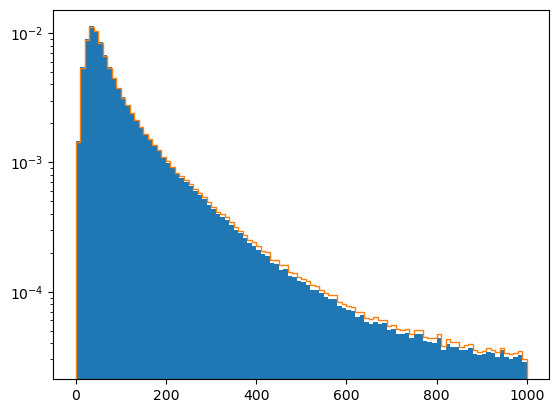

In [37]:
plt.hist(dijet_other, log=True, range=(0,1000), bins=100, density=True)
plt.hist(dijet_all, log=True, range=(0,1000), bins=100, density=True, histtype='step')
pass

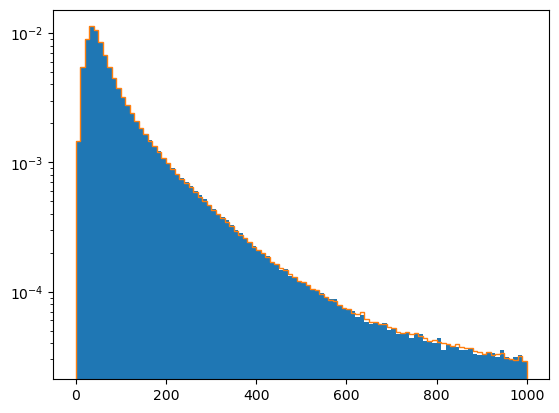

In [39]:
plt.hist(dijet_other, log=True, range=(0,1000), bins=100, density=True)
plt.hist(dijet_nugun, log=True, range=(0,1000), bins=100, density=True, histtype='step')
pass

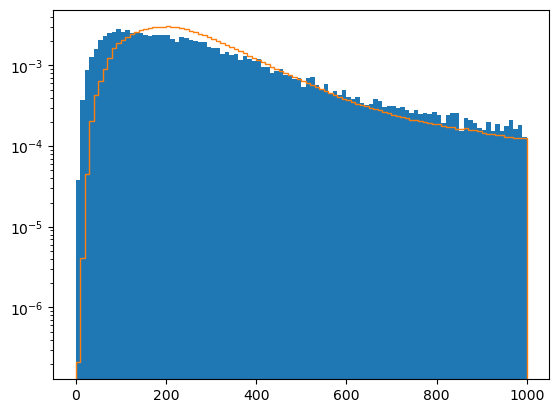

In [47]:
plt.hist(dijet_anom, log=True, range=(0,1000), bins=100, density=True)
plt.hist(dijet_tautau, log=True, range=(0,1000), bins=100, density=True, histtype='step')
pass

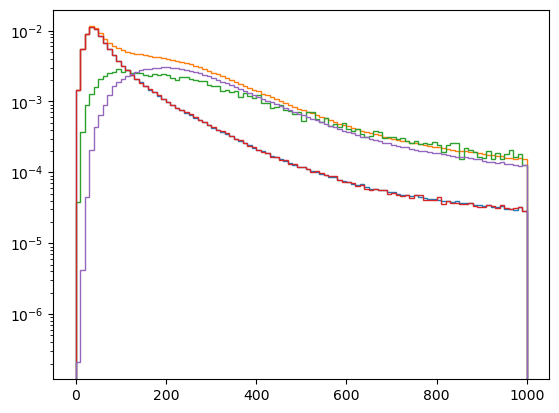

In [45]:
plt.hist(dijet_tautau, log=True, range=(0,1000), histtype='step', density=True, bins=100, bottom=plt.hist(dijet_nugun, histtype='step', range=(0,1000), bins=100, density=True)[0])
plt.hist(dijet_anom, log=True, range=(0,1000), bins=100, density=True, histtype='step')
plt.hist(dijet_other, log=True, range=(0,1000), bins=100, density=True, histtype='step')
plt.hist(dijet_tautau, log=True, range=(0,1000), bins=100, density=True, histtype='step')
pass

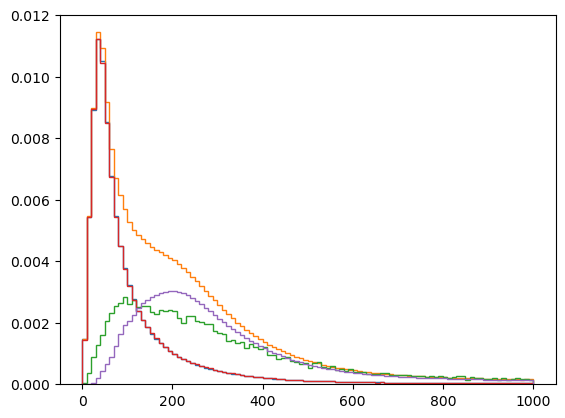

In [48]:
plt.hist(dijet_tautau, range=(0,1000), histtype='step', density=True, bins=100, bottom=plt.hist(dijet_nugun, histtype='step', range=(0,1000), bins=100, density=True)[0])
plt.hist(dijet_anom, range=(0,1000), bins=100, density=True, histtype='step')
plt.hist(dijet_other, range=(0,1000), bins=100, density=True, histtype='step')
plt.hist(dijet_tautau, range=(0,1000), bins=100, density=True, histtype='step')
pass

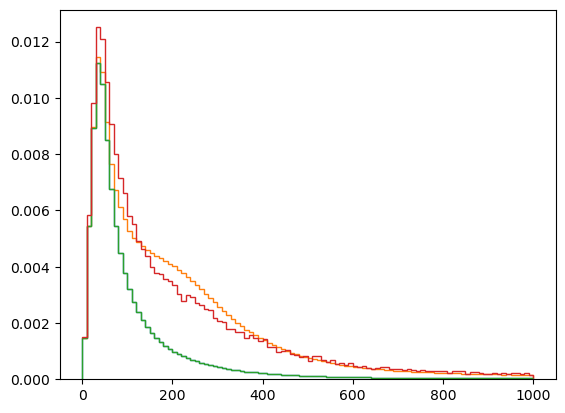

In [51]:
plt.hist(dijet_tautau, range=(0,1000), histtype='step', density=True, bins=100, bottom=plt.hist(dijet_nugun, histtype='step', range=(0,1000), bins=100, density=True)[0])

plt.hist(dijet_anom, range=(0,1000), histtype='step', density=True, bins=100, bottom=plt.hist(dijet_nugun, histtype='step', range=(0,1000), bins=100, density=True)[0])
pass